In [1]:
import numpy as np
import torch,  os
import pandas as pd
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import cv2

In [2]:
# load data

train_df = pd.read_csv(r'./train.csv')
test_df = pd.read_csv(r'./test.csv')
train_picture_path=  r'./train'
test_picture_path = r'./test_images/'

# setting area 
zoom=32
IMG_SIZE = zoom
NUM_CLASSES = 10
GRAYSCALE = False
num_features = 784

In [3]:
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [3]:
def load_images(x,zoom , dir_path):
    return cv2.resize(cv2.imread(os.path.join(dir_path , x)),(zoom,zoom))

In [4]:
# Create a Dataset to hold the input data and make it available to dataloader
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i]
        data = np.array(data).astype(np.uint8).reshape(IMG_SIZE, IMG_SIZE, 3)
        
        if self.transforms:
            data = self.transforms(data)
            
            # Also return label if we have it
            if self.y is not None:
                return (data, self.y[i])
            else:
                return data    

In [8]:
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [5]:
train_df['Data'] = train_df['ID'].apply(lambda x : load_images(x,zoom , train_picture_path))
test_df['Data'] = test_df['ID'].apply(lambda x : load_images(x , zoom, test_picture_path))

In [6]:
all_train_labels=train_df['Label']
all_train_images = train_df['Data']

test_images = test_df['Data']

# Split training data so we have a small validation set and training set
train_images, val_images, train_labels, val_labels = train_test_split(all_train_images, all_train_labels, test_size=0.2)

# Reindex so we can refer to first element using index 0
train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

In [7]:
# Training Image transformations
train_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
]
)
# Validation Image transformations
val_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
]
)


In [8]:
# Create data loaders
batch_size = 64

train_dataset = MyDataset(train_images, train_labels, train_trans)
val_dataset = MyDataset(val_images, val_labels, val_trans)
test_dataset = MyDataset(test_images, None, val_trans)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


<h1><center> -  DenseNet Architecture</center>
<img src='pic/DenseNet Architecture -1.jpg'>

<img src='pic/DenseNet Architecture -2.jpg'>

<img src='pic/DenseNet Architecture -3.jpg'>

In [9]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict



def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet121(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_featuremaps (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        
        return logits

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [11]:
model

DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

In [12]:
# Train the model

epochs = 30

train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Clear last image's results
        optimizer.zero_grad()
        log_ps = model(images)
        loss = F.cross_entropy(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        val_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                log_ps = model(images)
                val_loss +=  F.cross_entropy(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
             "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
             "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader)),
             "Accuracy: {:.3f}".format(accuracy/len(val_loader)))
        

Epoch: 1/30..  Training Loss: 2.021..  Validation Loss: 1.851..  Accuracy: 0.436
Epoch: 2/30..  Training Loss: 1.691..  Validation Loss: 1.603..  Accuracy: 0.543
Epoch: 3/30..  Training Loss: 1.483..  Validation Loss: 1.435..  Accuracy: 0.588
Epoch: 4/30..  Training Loss: 1.305..  Validation Loss: 1.288..  Accuracy: 0.629
Epoch: 5/30..  Training Loss: 1.185..  Validation Loss: 1.211..  Accuracy: 0.603
Epoch: 6/30..  Training Loss: 1.088..  Validation Loss: 1.105..  Accuracy: 0.660
Epoch: 7/30..  Training Loss: 0.993..  Validation Loss: 1.048..  Accuracy: 0.660
Epoch: 8/30..  Training Loss: 0.919..  Validation Loss: 1.003..  Accuracy: 0.669
Epoch: 9/30..  Training Loss: 0.845..  Validation Loss: 0.938..  Accuracy: 0.682
Epoch: 10/30..  Training Loss: 0.768..  Validation Loss: 0.892..  Accuracy: 0.707
Epoch: 11/30..  Training Loss: 0.711..  Validation Loss: 0.881..  Accuracy: 0.687
Epoch: 12/30..  Training Loss: 0.661..  Validation Loss: 0.837..  Accuracy: 0.713
Epoch: 13/30..  Training 

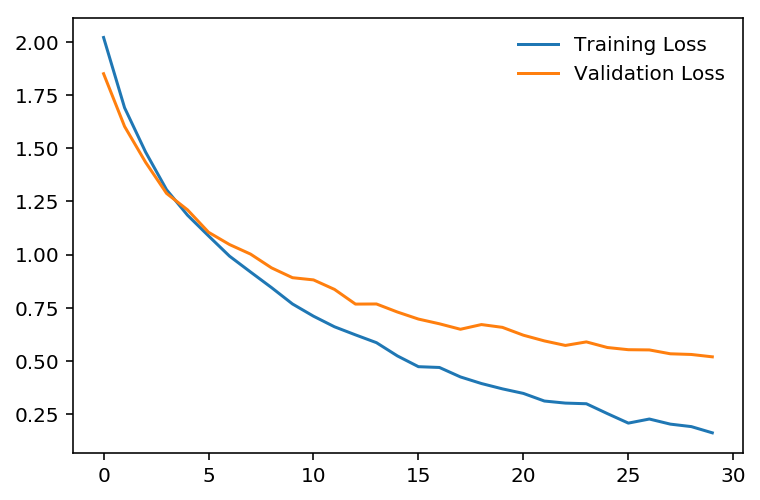

In [13]:
# Plot the losses
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(frameon=False);